In [ ]:
!pip install -U dm-haiku

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 kB 8.8 MB/s eta 0:00:00


In [ ]:
import haiku as hk
rng_seq = hk.PRNGSequence(np.random.randint(2**32))

In [ ]:
import numpy as np
import pandas as pd
import plotnine as gg
gg.theme_set(gg.theme_classic)  # for nicer-looking plots
import jax.numpy as jnp
import jax

# Part 1: Human Behavior

In this Colab, we will put to practive what we've learned in today's lecture:
* **We will first train an RL agent to perform a task, using policy evaluation and policy improvement.**
* **After that, we will fit an RL model to a real human dataset, and analyze (fake) fMRI data!**

To get started, let's first load our dataset to get it out of the way. Execute the following cell to load the dataset from gitbub into this Colab.

In [ ]:
# # Option 1
# human_data = pd.read_csv("./bahrami_100.csv")

# Option 1 (in case option 1 doesn't work)
from google.colab import files
import io
uploaded = files.upload()
human_data = pd.read_csv(io.BytesIO(uploaded['bahrami_100.csv']))

human_data

Saving bahrami_100.csv to bahrami_100.csv


,participant_id,action,reward,response_time,reward_action0,reward_action1,reward_action2,reward_action3,trial_id,missed
0,0,0.0,84.0,1104.0,84,87,42,23,0,False
1,0,1.0,90.0,1076.0,90,90,46,18,1,False
2,0,2.0,53.0,612.0,80,84,53,28,2,False
3,0,3.0,24.0,742.0,87,81,50,24,3,False
4,0,1.0,92.0,927.0,86,92,61,28,4,False
...,...,...,...,...,...,...,...,...,...,...
14995,99,2.0,62.0,679.0,47,35,62,48,145,False
14996,99,2.0,61.0,686.0,46,47,61,57,146,False
14997,99,2.0,70.0,600.0,46,35,70,43,147,False
14998,99,2.0,60.0,641.0,46,44,60,59,148,False


First, let's understand our task. We are working with a "4-armed bandit task". The figure below depicts what is happening on each trial of this task from participants' perspective:

<center><img src="https://github.com/trendinafrica/Comp_Neuro-ML_course/blob/main/notebooks/23-Friday/TaskOverview.png?raw=1" width=1000></center>

## Exercise 1: Understand the task (*5 minutes*)

* Find a partner (turn to your neighbor)
* Together, understand the task design:
  * First, let the person sitting left explain the first two stages ("Participant choice" and "Chosen stimulus") to the person sitting right. (*2 minutes*)
  * Then, let the person sitting right explain the last two stages ("Reward" and "Inter-trial interval") to the person sitting left. (*1 minute*)
  * Lastly, talk about any questions you still have about this task. (*2 minutes*)

## Solution 1

Now, expand the cells below to see the solution.

Participants perform the task on a computer. On each trial of the task, participants see four items on the screen (which we sometimes call "bandits"). In the "participant choice" stage, participants have 4 seconds to pick one of the bandits, using four keys on their keyboard ("d", "f", "j", and "k"). Once the participant has made a choice, all bandit except the selected one disappear, and only the selected one stays on the screen for 400 miliseconds (0.4 seconds). Then, the reward is displayed: Participants can win between 1-100 points on each trial, depending on which bandit they choose. The reward stays on the screen for 800 miliseconds, then a fixation cross appears in the center of the screen for half a second. After the fixation cross, participants enter the next trial, which is structured in the same way.

In this task, participants do a total of 150 trials, and thereby learn which bandits tend to give more points than others, so they can maximize the points they win. Let's take a look at the dataset!

In [ ]:
human_data

,participant_id,action,reward,response_time,reward_action0,reward_action1,reward_action2,reward_action3,trial_id,missed
0,0,0.0,84.0,1104.0,84,87,42,23,0,False
1,0,1.0,90.0,1076.0,90,90,46,18,1,False
2,0,2.0,53.0,612.0,80,84,53,28,2,False
3,0,3.0,24.0,742.0,87,81,50,24,3,False
4,0,1.0,92.0,927.0,86,92,61,28,4,False
...,...,...,...,...,...,...,...,...,...,...
14995,99,2.0,62.0,679.0,47,35,62,48,145,False
14996,99,2.0,61.0,686.0,46,47,61,57,146,False
14997,99,2.0,70.0,600.0,46,35,70,43,147,False
14998,99,2.0,60.0,641.0,46,44,60,59,148,False


## Exercise 2: Dataset basic numbers (*5 minutes*)

With your partner or by yourself, answer the following questions:
* How many participants are in the dataset?
* How many trials did each participant perform?
* What are the minimum and maximum points to be gained per trial?

Use the starter code below to find the answers:

In [ ]:
# Number of participants (we are giving you the solution here already)
n_participants = len(np.unique(human_data['participant_id']))

# Number of trials
# ============== FILL IN THE BLANKS BELOW ================
n_trials = ...

# Number of bandits
# ============== FILL IN THE BLANKS BELOW ================
n_bandits = ...

# Min and max points
# ============== FILL IN THE BLANKS BELOW ================
min_points = ...
max_points = ...

# Print the results
print("Number of participants: {}".format(n_participants))
print("Number of trials per participant: {}".format(n_trials))
print("Number of bandits (available actions): {}".format(n_bandits))
print("Minimum number of points in this game: {}. Maximum number: {}".format(min_points, max_points))

Number of participants: 100
Number of trials per participant: Ellipsis
Number of bandits (available actions): Ellipsis
Minimum number of points in this game: Ellipsis. Maximum number: Ellipsis


In [ ]:
#@title Click to show Solution 2
# Number of participants
n_participants = len(np.unique(human_data['participant_id']))

# Number of trials
n_trials = len(np.unique(human_data['trial_id']))

# Number of bandits
n_bandits = len(np.unique(human_data['action'])) - 1  # action '-1' indicates missed trial

# Min and max points
min_points, max_points = min(human_data['reward']), max(human_data['reward'])

# Print the results
print("Number of participants: {}".format(n_participants))
print("Number of trials per participant: {}".format(n_trials))
print("Number of bandits (available actions): {}".format(n_bandits))
print("Minimum number of points in this game: {}. Maximum number: {}".format(min_points, max_points))

Number of participants: 100
Number of trials per participant: 150
Number of bandits (available actions): 4
Minimum number of points in this game: 0.0. Maximum number: 92.0


Let's understand this dataset.

Each row contains the data for one trial of one participant. (Saving data in this way is called the "long format".)

* The column `participant_id` tells us which participant the data is coming from. Each participant has an ID between 1-100
* The column `action` tell us which bandit the participant chose. Bandit are numbered between 0-3
* The column `reward` tells us how many points the partipants won on this trial, by selected the bandit they selected
* `response_time` tells us how long the participant took to select the bandit
* `reward_actionX` tells us what the reward would have been for each action, had the participant chosen it on this trial. This is the same for all participants

## Exercise 3: Visualize available points (*10 minutes*)
Now, let's vizualize how many points each bandit gives on each trial of the task. (You will need the columns `reward_actionX` for this exercise.)
* Plot trials (from 0-150) on the x-axis
* And plot the reward each bandit would have given (from 1-100) on the y-axis
* Select a different color for each bandit to distinguish them

Use the starter code below:

In [ ]:
# Let's first melt the dataset so that every row contains the reward ("value") of just one bandit ("variable")
long_data = pd.melt(human_data, id_vars=['participant_id', 'trial_id', 'action', 'reward', 'response_time', 'missed'])
long_data = long_data.replace({'reward_action{}'.format(i): 'Bandit {}'.format(i) for i in range(n_bandits)})
long_data

,participant_id,trial_id,action,reward,response_time,missed,variable,value
0,0,0,0.0,84.0,1104.0,False,Bandit 0,84
1,0,1,1.0,90.0,1076.0,False,Bandit 0,90
2,0,2,2.0,53.0,612.0,False,Bandit 0,80
3,0,3,3.0,24.0,742.0,False,Bandit 0,87
4,0,4,1.0,92.0,927.0,False,Bandit 0,86
...,...,...,...,...,...,...,...,...
59995,99,145,2.0,62.0,679.0,False,Bandit 3,48
59996,99,146,2.0,61.0,686.0,False,Bandit 3,57
59997,99,147,2.0,70.0,600.0,False,Bandit 3,43
59998,99,148,2.0,60.0,641.0,False,Bandit 3,59


In [ ]:
# Now, let's create the plot
# ============== FILL IN THE BLANKS BELOW ================
gg_points_over_trials = (gg.ggplot(long_data, gg.aes(x='...', y='...', color='...'))
 + gg.geom_point()
 + gg.labs(x='...', y='...', color='...')
 + gg.coord_cartesian(ylim=(0, 100))
)

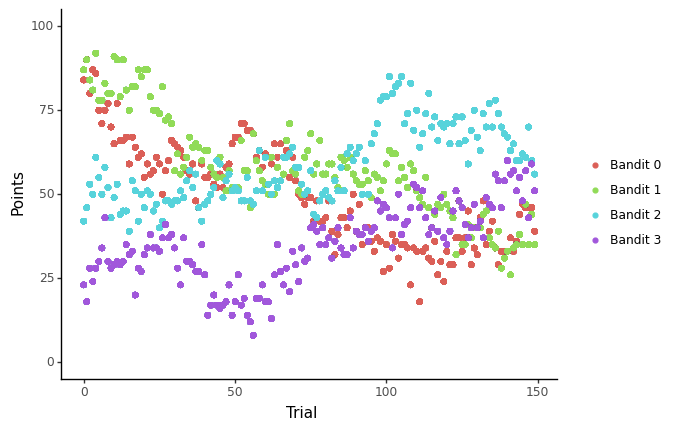

<ggplot: (8736888164319)>

In [ ]:
#@title Click to show Solution 3
gg_points_over_trials = (gg.ggplot(long_data, gg.aes(x='trial_id', y='value', color='variable'))
 + gg.geom_point()
 + gg.labs(x='Trial', y='Points', color='')
 + gg.coord_cartesian(ylim=(0, 100))
)
gg_points_over_trials

## Exercise 4: Visualize human behavior (*10 minutes*)

Now, let's vizualize which bandits participants chose on each trial of the task. (You will need the column `action` for this exercise.)
* Plot trials (from 0-150) on the x-axis
* And plot the proportion of participants who chose each bandit (from 0-100\%) on the y-axis
* Select a different color for each bandit to distinguish them

Use the starter code below:

In [ ]:
human_data

,participant_id,action,reward,response_time,reward_action0,reward_action1,reward_action2,reward_action3,trial_id,missed
0,0,0.0,84.0,1104.0,84,87,42,23,0,False
1,0,1.0,90.0,1076.0,90,90,46,18,1,False
2,0,2.0,53.0,612.0,80,84,53,28,2,False
3,0,3.0,24.0,742.0,87,81,50,24,3,False
4,0,1.0,92.0,927.0,86,92,61,28,4,False
...,...,...,...,...,...,...,...,...,...,...
14995,99,2.0,62.0,679.0,47,35,62,48,145,False
14996,99,2.0,61.0,686.0,46,47,61,57,146,False
14997,99,2.0,70.0,600.0,46,35,70,43,147,False
14998,99,2.0,60.0,641.0,46,44,60,59,148,False


In [ ]:
# Let's first add a separate "one-hot" column for each action that indicates of this action was chosen on this trial or not
action_cols = ['action_{}'.format(i) for i in range(n_bandits)]
human_data[action_cols] = jax.nn.one_hot(jnp.array(human_data['action']), n_bandits)
human_data

,participant_id,action,reward,response_time,reward_action0,reward_action1,reward_action2,reward_action3,trial_id,missed,action_0,action_1,action_2,action_3
0,0,0.0,84.0,1104.0,84,87,42,23,0,False,1.0,0.0,0.0,0.0
1,0,1.0,90.0,1076.0,90,90,46,18,1,False,0.0,1.0,0.0,0.0
2,0,2.0,53.0,612.0,80,84,53,28,2,False,0.0,0.0,1.0,0.0
3,0,3.0,24.0,742.0,87,81,50,24,3,False,0.0,0.0,0.0,1.0
4,0,1.0,92.0,927.0,86,92,61,28,4,False,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,99,2.0,62.0,679.0,47,35,62,48,145,False,0.0,0.0,1.0,0.0
14996,99,2.0,61.0,686.0,46,47,61,57,146,False,0.0,0.0,1.0,0.0
14997,99,2.0,70.0,600.0,46,35,70,43,147,False,0.0,0.0,1.0,0.0
14998,99,2.0,60.0,641.0,46,44,60,59,148,False,0.0,0.0,1.0,0.0


In [ ]:
# Now, let's melt the dataset again, so that every row contains just one action ("variable"), indicating whether it was chosen or not ("value")
long_data = pd.melt(human_data[['participant_id', 'trial_id'] + action_cols], id_vars=['participant_id', 'trial_id'])
long_data

,participant_id,trial_id,variable,value
0,0,0,action_0,1.0
1,0,1,action_0,0.0
2,0,2,action_0,0.0
3,0,3,action_0,0.0
4,0,4,action_0,0.0
...,...,...,...,...
59995,99,145,action_3,0.0
59996,99,146,action_3,0.0
59997,99,147,action_3,0.0
59998,99,148,action_3,0.0


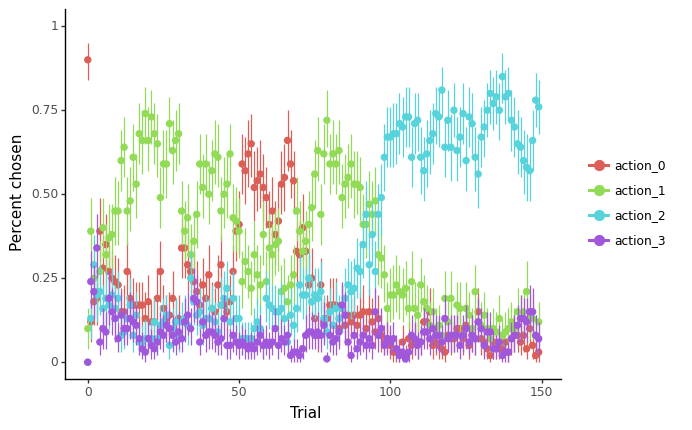

<ggplot: (8736803993997)>

In [ ]:
#@title Click to show Solution 4
gg_actions_over_trials = (gg.ggplot(long_data, gg.aes(x='trial_id', y='value', color='variable', group='variable'))
 + gg.stat_summary()
 + gg.labs(x='Trial', y='Percent chosen', color='')
 + gg.coord_cartesian(ylim=(0, 1))
)
gg_actions_over_trials

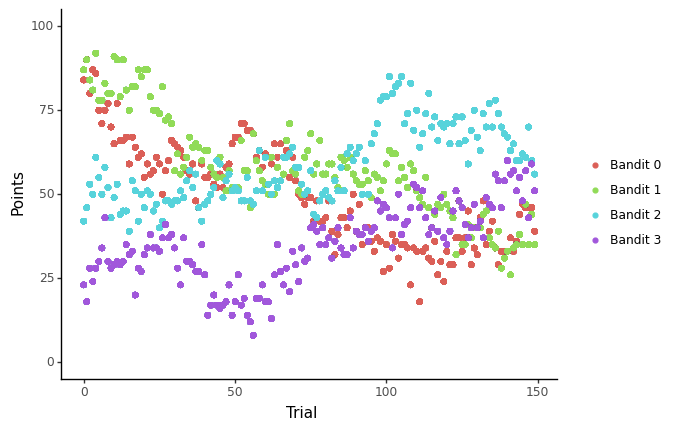

<ggplot: (8736888164319)>

In [ ]:
gg_points_over_trials

## Exercise 5: Interpret findings (*5 minutes*)

Compare the two plots you have made, showing the available points (Exercise 3) and showing human choices (Exercise 4).
* What do you notice?
* How do you explain the patterns you are seeing?

## Solution 5

Expand the cell below to see the solution.

The two plots look quite similar: When one color line is high in one plot, it also tends to be high in the other.

The explanation is that participants in this task learn to choose the bandits that give the most points: Whenever a line is high in the first plot, there are lots of points to be earned, and this drives up the line in the second plot, which shows that participants tend to choose the corresponding action.

# Part 2: Train an RL agent to solve the same task

Now that we know how humans are doing the task, let's see if we can train an AI agent to do it!

We heard about a few different approaches for how to do this in class, mainly:
* Rescorla Wagner
* TD learning
* Q-learning
* SARSA

## Exercise 1: Which method? (*5 minutes*)

With your partner or by yourself, think about which of these four methods would be best for our case.

(Hint: Look back at the task description and figures we made, and try to imagine what a value function and a policy would look like in this case. To chose one approach for training, consider if we need just a value function or also a policy; and whether we want to learn on-policy or off-policy.)

## Solution 1
Click below to expand.

We are interested in training an agent to *do* something, aka to *act*; therefore, we want to use an algorithm that learns an *action policy*, on top of a value function. This rules out Rescorla Wagner and TD learning, which only learn a value function (e.g., to predict Pavlovian responses), but no action policy.

We next have the choice between off-policy (Q-learning) and on-policy learning (SARSA): Whereas Q-learning calculates values based on the best action that *could have been chosen*, SARSA calculates values based on the action that *was actually chosen*. Because our environemnt is not stationary (aka, the rewards for the bandits are changing over time), the on-policy method works better here. Furthermore, SARSA usually uses a *stochastic* policy (aka, it selects actions with some random noise). This will also help us here because we need "exploration" (aka, picking random actions once in a while) to discover new actions in a changing environment.

## Exercise 2: Write the value function (*10 minutes*)

In [ ]:
class RlAgent():
  """Define classic alpha-beta RL model."""

  def __init__(self, n_actions, rl_parameters, init_value=0.5):

    self._n_actions = n_actions
    self._init_value = init_value
    self._alpha = rl_parameters['alpha']
    self._beta = rl_parameters['beta']

  def update_values(self, value, action, reward):
    """SARSA value update."""
    action_1h = jax.nn.one_hot(action, num_classes=self._n_actions)
    rpe = reward - jnp.sum(action_1h * value, axis=-1)  # shape: (batch_size,)
    new_value = value + action_1h * self._alpha * rpe[:, jnp.newaxis]  # shape: (batch_size, n_actions)

    return new_value

  def calculate_action_probs(self, value):
    return jax.nn.softmax(self._beta * value)  # shape: (batch_size, n_actions)

  def choose_action(self, action_probs):
    return jnp.array([jax.random.choice(next(rng_seq), a=jnp.arange(self._n_actions), p=action_probs[batch]) for batch in range(len(action_probs))])  # shape: (batch_size,)

  # def __call__(self, inputs: jnp.array, prev_state: jnp.array):
  #   prev_value = prev_state  # shape: (batch_size, n_actions)
  #   action = inputs[:, :self._n_actions]  # shape: (batch_size, n_actions)
  #   reward = inputs[:, -1]  # shape: (batch_size,)

  #   # Value update
  #   new_value = self.update_values(prev_value, action, reward)  # shape: (batch_size, n_actions)

  #   # Action selection probabilities
  #   action_probs = self.calculate_action_probs(new_value)  # shape: shape: (batch_size, n_actions)

  #   return action_probs, new_value

  def initial_values(self, batch_size):
    return self._init_value * jnp.ones([batch_size, self._n_actions])

In [ ]:
agent = RlAgent(n_actions=2, rl_parameters={'alpha': 0.3, 'beta': 3})
action = 1
reward = 1
batch_size = 1
n_trials = 4

agent_values = agent.initial_values(batch_size)
print(f'Action values {agent_values}')

for trial in range(n_trials):
  print(f'Trial {trial}')
  agent_values = agent.update_values(agent_values, action, reward)
  print(f'Action values {agent_values}')

action_probs = agent.calculate_action_probs(agent_values)
print(action_probs)
action = agent.choose_action(action_probs)
print(action)

Action values [[0.5 0.5]]
Trial 0
Action values [[0.5  0.65]]
Trial 1
Action values [[0.5   0.755]]
Trial 2
Action values [[0.5        0.82850003]]
Trial 3
Action values [[0.5        0.87995005]]
[[0.24234788 0.75765216]]
[1]


In [ ]:
human_data

,participant_id,action,reward,response_time,reward_action0,reward_action1,reward_action2,reward_action3,trial_id,missed,action_0,action_1,action_2,action_3
0,0,0.0,84.0,1104.0,84,87,42,23,0,False,1.0,0.0,0.0,0.0
1,0,1.0,90.0,1076.0,90,90,46,18,1,False,0.0,1.0,0.0,0.0
2,0,2.0,53.0,612.0,80,84,53,28,2,False,0.0,0.0,1.0,0.0
3,0,3.0,24.0,742.0,87,81,50,24,3,False,0.0,0.0,0.0,1.0
4,0,1.0,92.0,927.0,86,92,61,28,4,False,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,99,2.0,62.0,679.0,47,35,62,48,145,False,0.0,0.0,1.0,0.0
14996,99,2.0,61.0,686.0,46,47,61,57,146,False,0.0,0.0,1.0,0.0
14997,99,2.0,70.0,600.0,46,35,70,43,147,False,0.0,0.0,1.0,0.0
14998,99,2.0,60.0,641.0,46,44,60,59,148,False,0.0,0.0,1.0,0.0


In [ ]:
reward_schedule = human_data[['reward_action{}'.format(i) for i in range(n_bandits)]].values / 100
reward_schedule

array([[0.84, 0.87, 0.42, 0.23],
       [0.9 , 0.9 , 0.46, 0.18],
       [0.8 , 0.84, 0.53, 0.28],
       ...,
       [0.46, 0.35, 0.7 , 0.43],
       [0.46, 0.44, 0.6 , 0.59],
       [0.39, 0.35, 0.56, 0.51]])

In [ ]:
agent = RlAgent(n_actions=2, rl_parameters={'alpha': 0.3, 'beta': 3})
agent_values = agent.initial_values(batch_size)
print(f'Action values {agent_values}')

for trial in range(n_trials):

  print(f'\nTrial {trial}')

  action_probs = agent.calculate_action_probs(agent_values)
  print(f'Action probabilities {action_probs}')

  action = agent.choose_action(action_probs)
  print(f'Chosen action {action}')

  reward = reward_schedule[trial, action]
  print(f'Obtained reward {reward}')

  agent_values = agent.update_values(agent_values, action, reward)
  print(f'Action values {agent_values}')

Action values [[0.5 0.5]]

Trial 0
Action probabilities [[0.5 0.5]]
Chosen action [1]
Obtained reward [0.87]
Action values [[0.5   0.611]]

Trial 1
Action probabilities [[0.4175109  0.58248913]]
Chosen action [1]
Obtained reward [0.9]
Action values [[0.5    0.6977]]

Trial 2
Action probabilities [[0.35592386 0.6440761 ]]
Chosen action [0]
Obtained reward [0.8]
Action values [[0.59000003 0.6977    ]]

Trial 3
Action probabilities [[0.41992044 0.58007956]]
Chosen action [0]
Obtained reward [0.87]
Action values [[0.674  0.6977]]


In [ ]:
# PROVIDE class for Q-learning agent: random behavioral policy, but calculates Q-values according to Bellman/Q-Update
# TASK 2a: Let the agent perform the task (fill in some pieces of code here and there to complete the loop)
# TASK 2b: Inspect the behavior (should be random)
# TASK 2c: Inspect the value function (should approximate plots above)
# TASK 2d: Describe what we have done. (-> Policy Evaluation). What is missing? -> Policy Improvement.
# TASK 2e: Implement the policy improvement step (Choose actions according to values)
# TASK 2f: Replot behavior (should now look like humans)
# TASK 2g: Describe your results in words.

## Exercise X: Simulate agents

Simulate 50 agents on this task and plot them in the same way as the human dataset.

## Exercise X: Interpret simulation

What do you see? How do the agents compare to humans? What are the most striking similarities and differences?

# Part 3: Use RL as a model for human behavior

We have now trained an RL agent to perform the task. We next want to test if humans might be using RL in a similar way to learn the task. How can we do this?

To see if humans use RL to solve the task, we "fit" the RL model to human behavior. This means that we "squeeze" and "stretch" the RL agent until it produces behavior that corresponds to the human behavior.

In this case, the "squeezing" and "stretching" consists of increasing or decreasing the values of the *free parameters* of the model, $\alpha$ and $\beta$.

How do we know if we need to increase or decrease the values? By checking how close the behavior of the model is to human behavior. The closer the model behavior matches human behavior, the better the model "fits" the human dataset. We want the best possible fit, so we are looking for the values of $\alpha$ and $\beta$ that *maximizes the probability* that the RL model chooses the same actions that humans have chosen.

**In other (more fancy) words, our goal is to find the values for our model parameters ($\alpha$ and $\beta$) that maximize the likelihood of the observed (human) behavior under the model.**

To do this, we first need to know how likey the observed behavior is under each model. Once we know, all we have to do is to maximize this likelihood.

**TASK 1**: Calculate the likelihood of the human dataset under model parameters $\alpha=0.3$ and $\beta=3$, by filling in the blanks below.

**TASK 2**: Maximize the likelihood of the human dataset by finding the optimal parameters. Fill in the blanks below.

In [ ]:
example_participant = human_data.loc[human_data['participant_id'] == 0, ['action', 'reward']]
example_participant['reward'] /= 100
example_participant

,action,reward
0,0.0,0.84
1,1.0,0.90
2,2.0,0.53
3,3.0,0.24
4,1.0,0.92
...,...,...
145,3.0,0.48
146,2.0,0.61
147,2.0,0.70
148,2.0,0.60


In [ ]:
agent = RlAgent(n_actions=2, rl_parameters={'alpha': 0.3, 'beta': 3})
agent_values = agent.initial_values(batch_size)
all_values = []
all_actions = []

print(f'Action values {agent_values}')

for trial in range(n_trials):

  print(f'\nTrial {trial}')

  action_probs = agent.calculate_action_probs(agent_values)
  print(f'Action probabilities {action_probs}')

  action = example_participant.iloc[trial]['action']
  all_actions.append(action)
  print(f'Participant\'s action {action}')

  reward = example_participant.iloc[trial]['reward']
  print(f'Participant\'s reward {reward}')

  agent_values = agent.update_values(agent_values, action, reward)
  all_values.append(agent_values)
  print(f'Action values {agent_values}')

np.array(all_values)
np.array(jax.nn.one_hot(all_actions, num_classes=n_bandits))

Action values [[0.5 0.5]]

Trial 0
Action probabilities [[0.5 0.5]]
Participant's action 0.0
Participant's reward 0.84
Action values [[0.602 0.5  ]]

Trial 1
Action probabilities [[0.5759086 0.4240914]]
Participant's action 1.0
Participant's reward 0.9
Action values [[0.602 0.62 ]]

Trial 2
Action probabilities [[0.4865033  0.51349676]]
Participant's action 2.0
Participant's reward 0.53
Action values [[0.602 0.62 ]]

Trial 3
Action probabilities [[0.4865033  0.51349676]]
Participant's action 3.0
Participant's reward 0.24
Action values [[0.602 0.62 ]]


array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]], dtype=float32)

In [ ]:
human_data.loc[human_data['trial_id'] == 1, 'action'].values

array([ 1.,  1.,  3.,  3.,  1.,  3.,  0.,  1.,  1.,  1.,  1.,  3.,  1.,
        2.,  0., -1.,  3.,  1.,  1.,  3.,  2.,  1.,  1.,  3.,  3., -1.,
        3., -1.,  1.,  3.,  3.,  3., -1.,  1.,  1.,  0.,  3., -1.,  3.,
        0.,  2.,  2.,  1.,  1.,  1.,  1.,  3.,  1.,  1.,  0.,  3.,  1.,
        3., -1., -1.,  2.,  3.,  1.,  1.,  1.,  2.,  2.,  1.,  1.,  1.,
        1.,  0.,  2.,  1., -1.,  2., -1.,  1.,  0.,  2.,  1., -1.,  0.,
        3.,  1.,  3.,  3.,  1., -1.,  1.,  0.,  1.,  1.,  1.,  0.,  3.,
        2., -1.,  2.,  0.,  1.,  0.,  2.,  3.,  3.])

In [ ]:
agent = RlAgent(n_actions=n_bandits, rl_parameters={'alpha': 0.3, 'beta': 3})
batch_size = 2
n_trials = 8
agent_values = agent.initial_values(batch_size)
all_values = []
all_action_probs = []
all_actions = []

print(f'Action values {agent_values}')

for trial in range(n_trials):

  print(f'\nTrial {trial}')

  action_probs = agent.calculate_action_probs(agent_values)
  all_action_probs.append(action_probs)
  print(f'Action probabilities {action_probs}')

  action = human_data.loc[human_data['trial_id'] == trial, 'action'].values[:batch_size]
  all_actions.append(action)
  print(f'Participants\' actions {action}')

  reward = human_data.loc[human_data['trial_id'] == trial, 'reward'].values[:batch_size]
  print(f'Participants\' rewards {reward}')

  agent_values = agent.update_values(agent_values, action, reward)
  all_values.append(agent_values)
  print(f'Action values {agent_values}')

np.array(all_values)
np.array(jax.nn.one_hot(all_actions, num_classes=n_bandits))
np.array(all_action_probs)

Action values [[0.5 0.5 0.5 0.5]
 [0.5 0.5 0.5 0.5]]

Trial 0
Action probabilities [[0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]]
Participants' actions [0. 0.]
Participants' rewards [84. 84.]
Action values [[25.550001  0.5       0.5       0.5     ]
 [25.550001  0.5       0.5       0.5     ]]

Trial 1
Action probabilities [[1.0000000e+00 2.3055206e-33 2.3055206e-33 2.3055206e-33]
 [1.0000000e+00 2.3055206e-33 2.3055206e-33 2.3055206e-33]]
Participants' actions [1. 1.]
Participants' rewards [90. 90.]
Action values [[25.550001 27.35      0.5       0.5     ]
 [25.550001 27.35      0.5       0.5     ]]

Trial 2
Action probabilities [[4.49626613e-03 9.95503724e-01 1.03662344e-35 1.03662344e-35]
 [4.49626613e-03 9.95503724e-01 1.03662344e-35 1.03662344e-35]]
Participants' actions [2. 2.]
Participants' rewards [53. 53.]
Action values [[25.550001 27.35     16.25      0.5     ]
 [25.550001 27.35     16.25      0.5     ]]

Trial 3
Action probabilities [[4.49626613e-03 9.95503724e-01 3.43585871e-1

array([[[2.50000000e-01, 2.50000000e-01, 2.50000000e-01, 2.50000000e-01],
        [2.50000000e-01, 2.50000000e-01, 2.50000000e-01, 2.50000000e-01]],

       [[1.00000000e+00, 2.30552058e-33, 2.30552058e-33, 2.30552058e-33],
        [1.00000000e+00, 2.30552058e-33, 2.30552058e-33, 2.30552058e-33]],

       [[4.49626613e-03, 9.95503724e-01, 1.03662344e-35, 1.03662344e-35],
        [4.49626613e-03, 9.95503724e-01, 1.03662344e-35, 1.03662344e-35]],

       [[4.49626613e-03, 9.95503724e-01, 3.43585871e-15, 1.03662344e-35],
        [4.49626613e-03, 9.95503724e-01, 3.43585871e-15, 1.03662344e-35]],

       [[4.49626613e-03, 9.95503724e-01, 3.43585871e-15, 1.58836388e-26],
        [4.49626613e-03, 9.95503724e-01, 3.43585871e-15, 1.58836388e-26]],

       [[2.42872935e-28, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [2.42872935e-28, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 1

In [ ]:
def calculate_neg_log_likelihood(agent, batch_size, n_trials):

  agent_values = agent.initial_values(batch_size)
  all_values = []
  all_action_probs = []
  all_actions = []

  for trial in range(n_trials):

    action_probs = agent.calculate_action_probs(agent_values)
    all_action_probs.append(action_probs)

    action = human_data.loc[human_data['trial_id'] == trial, 'action'].values[:batch_size]
    all_actions.append(action)

    reward = human_data.loc[human_data['trial_id'] == trial, 'reward'].values[:batch_size] / 100

    agent_values = agent.update_values(agent_values, action, reward)
    all_values.append(agent_values)

  all_actions_1h = np.array(jax.nn.one_hot(all_actions, num_classes=n_bandits))
  action_likelihoods = np.sum(all_actions_1h * np.array(all_action_probs), axis=-1)

  return -np.mean(np.log(action_likelihoods + 1e-5))

In [ ]:
agent = RlAgent(n_actions=n_bandits, rl_parameters={'alpha': 0.3, 'beta': 3})
n_trials = 8

calculate_neg_log_likelihood(agent, batch_size, n_trials)

1.3686652

In [29]:
nlls = []
n_points_sqrt = 50
batch_size = 100
n_trials = 150
min_beta = 1.
max_beta = 30.

for alpha in np.arange(n_points_sqrt) / n_points_sqrt:
  print(alpha)
  for beta in min_beta + np.arange(n_points_sqrt) / n_points_sqrt * max_beta:

    agent = RlAgent(n_actions=n_bandits, rl_parameters={'alpha': alpha, 'beta': beta})
    nll = calculate_neg_log_likelihood(agent, batch_size, n_trials)

    nlls.append([alpha, beta, nll])

nlls = pd.DataFrame(nlls, columns=['alpha', 'beta', 'nll'])

0.0
0.02
0.04
0.06
0.08
0.1
0.12
0.14
0.16
0.18
0.2
0.22
0.24
0.26
0.28
0.3
0.32
0.34
0.36
0.38
0.4
0.42
0.44
0.46
0.48
0.5
0.52
0.54
0.56
0.58
0.6
0.62
0.64
0.66
0.68
0.7
0.72
0.74
0.76
0.78
0.8
0.82
0.84
0.86
0.88
0.9
0.92
0.94
0.96
0.98


**NOTE**: In reality, we would use a *function optimizer* to find the best parameters, instead of doing *grid search* like we did above.

*Grid search* means that we manually calculate results for the entire "grid" of possible solutions. In this case, we manually calculated the NLLs for each possible pair of $\alpha$ and $\beta$. We then look at the grid and find the spot with the best result, aka the smallest NLL.

*Function optimization* means that we automatize this entire process: We submit our NLL function to an optimizer that automatically finds the minimum of the function. This saves time because function optimizers are usually very fast and have smarter strategies for finding a minimum than checking everywhere.

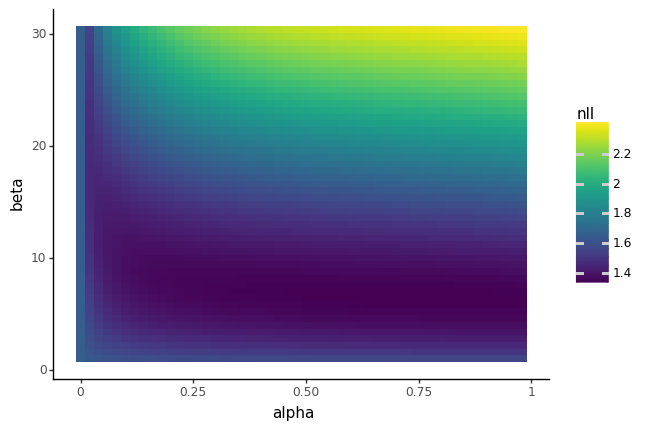

<ggplot: (8736803514008)>

In [30]:
nll_plot = (gg.ggplot(nlls, gg.aes(x='alpha', y='beta', fill='nll'))
 + gg.geom_tile()
)
nll_plot

Here is a high-resolution version of the same plot:

<center><img src="https://github.com/trendinafrica/Comp_Neuro-ML_course/blob/main/notebooks/23-Friday/NllGrid.png" width=1000></center>

## Exercise 4: Interpret findings (*10 minutes*)

What do you conclude from our results? What did the "fitting" procedure reveal about human choices in this task?

## Exercise X: Simulate agents, plot, interpret

## Exercise 5: Going beyond (*10 minutes*)

What are the advantages and disadvantages of this method, in your opinion? What are the limitations? What would we have to do to go beyond these limitations?

In [31]:
# Use the same agent, set alpha and beta to the values above. calculate likelihood for one subject.
# Write the loss function: negative log likelihood.
# Set up a loop that performs SGD on the loss function.
# TASK 3: Simulate behavior from the agent with the fitted parameters.
# TASK 3b: Plot the behavior like before. Is it closer to humans?

# Part 4: Use RL as a neural model

Like we've seen in the lecture, there is lots of evidence that the brain might implent an RL algorithm: Most notably, the dopamine system has been argued to calculate reward prediction errors (RPEs), such that dopamine neurons *increase* their firing rates when there is a *positive* RPE (reward is *larger* than expected), and *decrease* their firing rates when there is a *negative* RPE (reward is *smaller* than expected).

In this section, we will see if this is the case in our dataset.

TASK 1: Calculate RPEs. For each trial in the task, calculate the RPE the model is encountering. (Make sure you save the RPEs for each trial so we can later compare them to human striatal activity.)

TASK 2: Plot the model-based RPEs against the human fMRI signal (RPEs on the y-axis and BOLD signal on the x-axis). What do you see?

TASK 3: Calcualte the correlation between model-based RPEs and striatal BOLD signal. What do you conclude about the hypothesis that the striatal dopamine systems encodes RPEs?

In [32]:
# TASK 4: Calculate RPEs in the model (already done; just need to save)
# TASK 4b: Plot
# TASK 4c: Calculate correlation

# Part 5: Improve the model by adding more processes

In [32]:
# copy agent from above; give equation for forgetting; elipsis in the code
# fit, using SGD

# Part 6: Model comparison

In [32]:
# calculate AIC / held-out fit of RLab and RLabf
# model comparison

# Bonus: Fit a neural network to human behavior